In [1]:
import scipy
import numpy as np
import scipy.io.wavfile as wavfile
import matplotlib.pyplot as plt
from scipy.linalg import svd
%matplotlib inline

/Users/briann/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


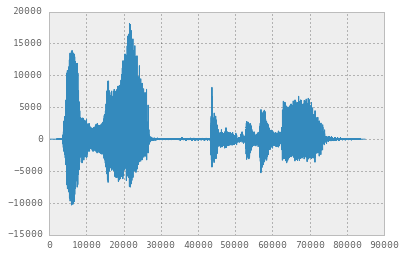

In [2]:
rate, wav = wavfile.read("voice.wav")
_ = plt.plot(wav)
!afplay voice.wav

In [31]:
def stft(x, fftsize=1024, overlap=4):   
    hop = fftsize // overlap
    w = scipy.hanning(fftsize+1)[:-1]      # better reconstruction with this trick +1)[:-1]  
    return np.array([np.fft.rfft(w*x[i:i+fftsize]) for i in range(0, len(x)-fftsize, hop)])

def istft(X, overlap=4):   
    fftsize=(X.shape[1]-1)*2
    hop = fftsize // overlap
    w = scipy.hanning(fftsize+1)[:-1]
    x = scipy.zeros(X.shape[0]*hop)
    wsum = scipy.zeros(X.shape[0]*hop) 
    for n,i in enumerate(range(0, len(x)-fftsize, hop)): 
        x[i:i+fftsize] += scipy.real(np.fft.irfft(X[n])) * w   # overlap-add
        wsum[i:i+fftsize] += w ** 2.
    pos = wsum != 0
    x[pos] /= wsum[pos]
    return x

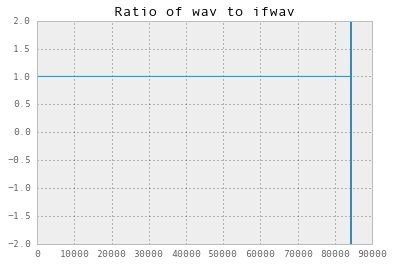

In [4]:
# FFT and inverse FFT
fwav = stft(wav, fftsize=512, overlap=10)
ifwav = istft(fwav, overlap=10)

# inverse FFT comparison
vals = (wav[:len(ifwav)]+1e-3) / (ifwav[:len(wav)]+1e-3)
plt.title("Ratio of wav to ifwav")
plt.plot(vals)
plt.ylim(-2,2)
wavfile.write("ifwav.wav", rate, ifwav.astype(wav.dtype))

difference 300.183777964
[  0 113  28 ...,   0   0   0]
[-1  2 -2 ...,  0  1 -3]


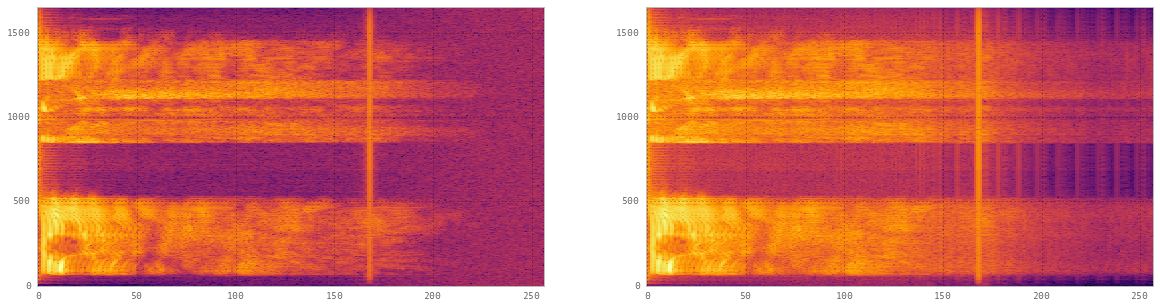

In [28]:
# Spectrogram
f, ax = plt.subplots(figsize=(20,5), ncols=2, nrows=1)
ax[0].imshow(np.log(np.abs(fwav)), interpolation='nearest', origin='lower', aspect='auto', cmap='inferno')

# SVD to reconstruct
N = 100 # number of principal components
U, s, V = svd(fwav)
S = np.zeros((U.shape[0], V.shape[0]), dtype=complex)
S[:len(s), :len(s)] = np.diag(s)
rec = np.dot(U[:,:N], np.dot(S[:N,:N], V[:N,:]))

print "difference",np.abs(fwav - rec).mean()

irec = istft(rec, overlap=10).astype(wav.dtype)
ax[1].imshow(np.log(np.abs(rec)), interpolation='nearest', origin='lower', aspect='auto', cmap='inferno')

print irec
print wav
wavfile.write("irec.wav", rate, irec)

In [30]:
!afplay irec.wav